# SBS SMK Test

This notebook should be used as a test for ensuring correct SBS image loading and processing before running a snakemake workflow.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from IPython.display import display
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

from ops.sbs_smk import Snake_sbs
import ops
from ops.imports_ipython import *
from ops.qc import *

## Helper Functions

In [2]:
# Function to generate file paths
def generate_file_paths(input_files_dir, preprocess_pattern, well, tile, sbs_cycles):
    file_paths = []

    # All cycles (all channels)
    for cycle in sbs_cycles:
        cycle_file_name = preprocess_pattern.format(
            cycle=cycle, well=well, tile=tile)
        cycle_file_path = f"{input_files_dir}/{cycle_file_name}"
        file_paths.append(cycle_file_path)

    return file_paths

# Custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    colmat = np.random.rand(num_colors, 4)
    colmat[:, -1] = alpha
    # Set the first color to black with full transparency
    colmat[0, :] = [0, 0, 0, 1]
    cmap = matplotlib.colors.ListedColormap(colmat)
    return cmap

## SET PARAMETERS

### Loading, aligning, detecting candiate reads

- `INPUT_FILES_DIR`: Directory for loading 

- `SBS_CYCLES`: The number and order of SBS cycles
- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `preprocess_pattern`: The channel names and file naming conventions
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data

In [3]:
# Directory for loading and saving files
INPUT_FILES_DIR = "input"
OUTPUT_FILES_DIR = "output/test"

# Define lists of cycles
SBS_CYCLES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
CYCLE_FILES = None

# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = "A1"
TILES = 1
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = None

# Define the file pattern
PREPROCESS_PATTERN = "10X_c{cycle}-SBS-{cycle}_{well}_Tile-{tile}.sbs.tif"

# Define display ranges for different channels, recognized by ImageJ
DISPLAY_RANGES = [
    [500, 15000],  # Range for DAPI channel
    [100, 10000],  # Range for CY3 channel
    [100, 10000],  # Range for A594 channel
    [200, 25000],  # Range for CY5 channel
    [200, 25000],  # Range for CY7 channel
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,  # Lookup table for DAPI channel
    ops.io.GREEN,  # Lookup table for CY3 channel
    ops.io.RED,  # Lookup table for A594 channel
    ops.io.MAGENTA,  # Lookup table for CY5 channel
    ops.io.CYAN,  # Lookup table for CY7 channel
]

Loading input images...
Input images loaded: 11
Input file description: {'subdir': 'input/sbs_tifs', 'mag': '10X', 'well': 'A1', 'tile': '1', 'ext': 'tif'}
Aligning input images...
Shape of SBS images aligned across cycles: (11, 5, 1200, 1200)
Example aligned image for first cycle:


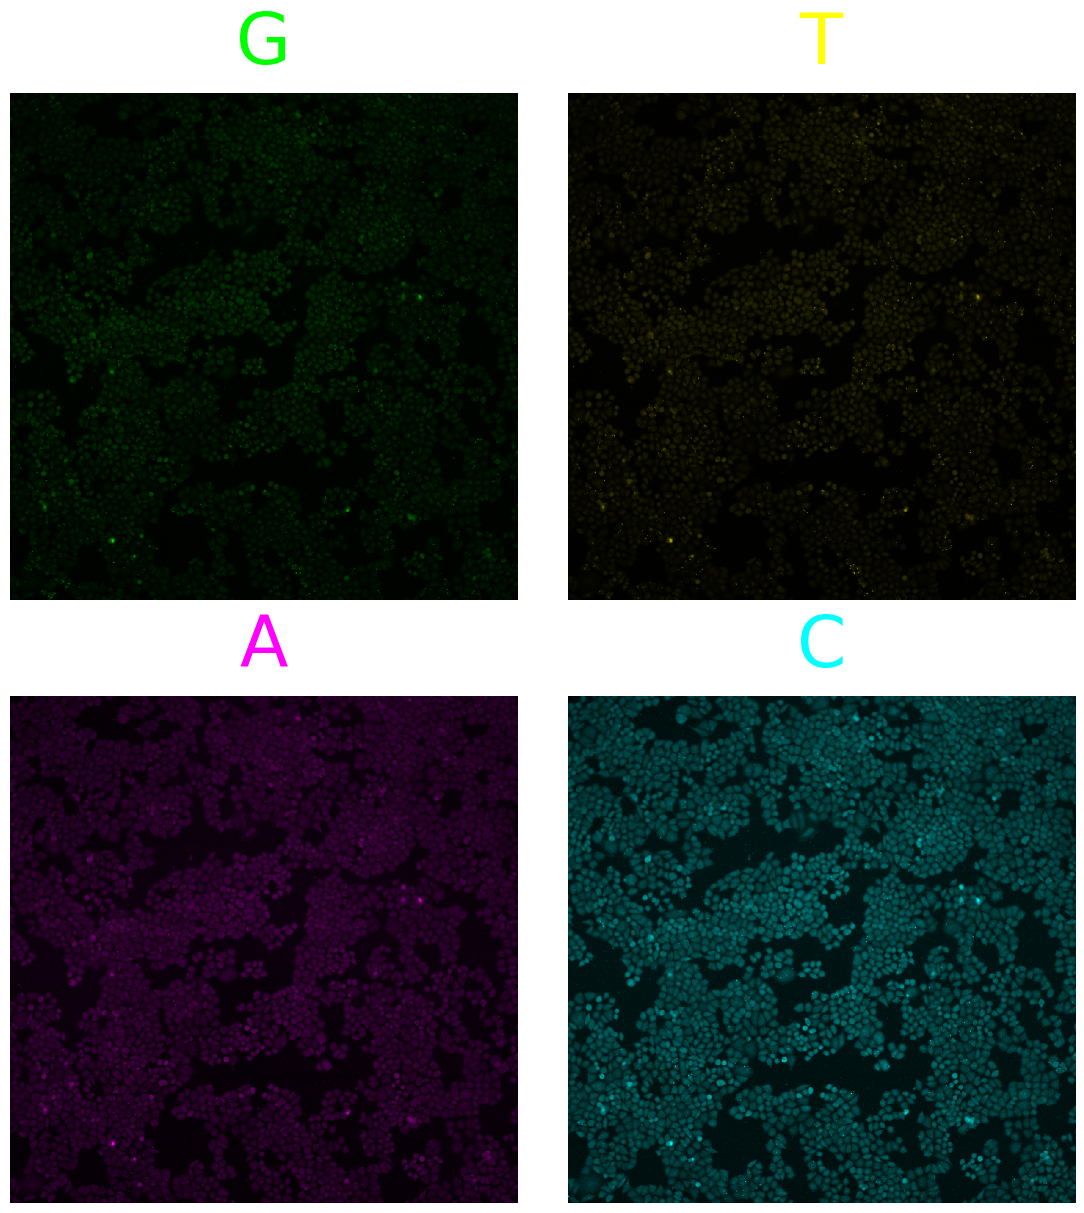

In [4]:
print("Loading input images...")
input_image_paths = generate_file_paths(
    f"{INPUT_FILES_DIR}/sbs_tifs", PREPROCESS_PATTERN, WELLS, TILES, SBS_CYCLES
)
input_images = [read(f) for f in input_image_paths]
print(f"Input images loaded: {len(input_images)}")
# parse description from input image
description = parse(input_image_paths[0])
keys_to_remove = ["cycle", "tag", "file"]
for key in keys_to_remove:
    description.pop(key, None)
print(f"Input file description: {description}")

print("Aligning input images...")
# This corresponds to the 'align' rule in Snakemake
aligned = Snake_sbs._align_SBS(
    input_images,
    method="SBS_mean",
    cycle_files=CYCLE_FILES,
    upsample_factor=1,
    n=1,
    keep_extras=False,
)
save(
    name(description, tag="aligned", subdir=OUTPUT_FILES_DIR),
    aligned,
    display_ranges=DISPLAY_RANGES,
    luts=LUTS,
)
# expected dimensions of (CYCLE, CHANNEL, I, J)
print(f"Shape of SBS images aligned across cycles: {aligned.shape}")

print("Example aligned image for first cycle:")
# show aligned for one round
g_aligned_microshow = microplot.Microimage(
    aligned[0, 1, :, :], cmaps="pure_green", channel_names="G"
)
t_aligned_microshow = microplot.Microimage(
    aligned[0, 2, :, :], cmaps="pure_yellow", channel_names="T"
)
a_aligned_microshow = microplot.Microimage(
    aligned[0, 3, :, :], cmaps="pure_magenta", channel_names="A"
)
c_aligned_microshow = microplot.Microimage(
    aligned[0, 4, :, :], cmaps="pure_cyan", channel_names="C"
)
panel = Micropanel(rows=2, cols=2, figscaling=6)
panel.add_element([0, 0], g_aligned_microshow)
panel.add_element([0, 1], t_aligned_microshow)
panel.add_element([1, 0], a_aligned_microshow)
panel.add_element([1, 1], c_aligned_microshow)
panel.add_channel_label()

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...
Computing standard deviation over cycles...
Applying max filter...
Finding peaks...
Example max filtered image for first cycle:


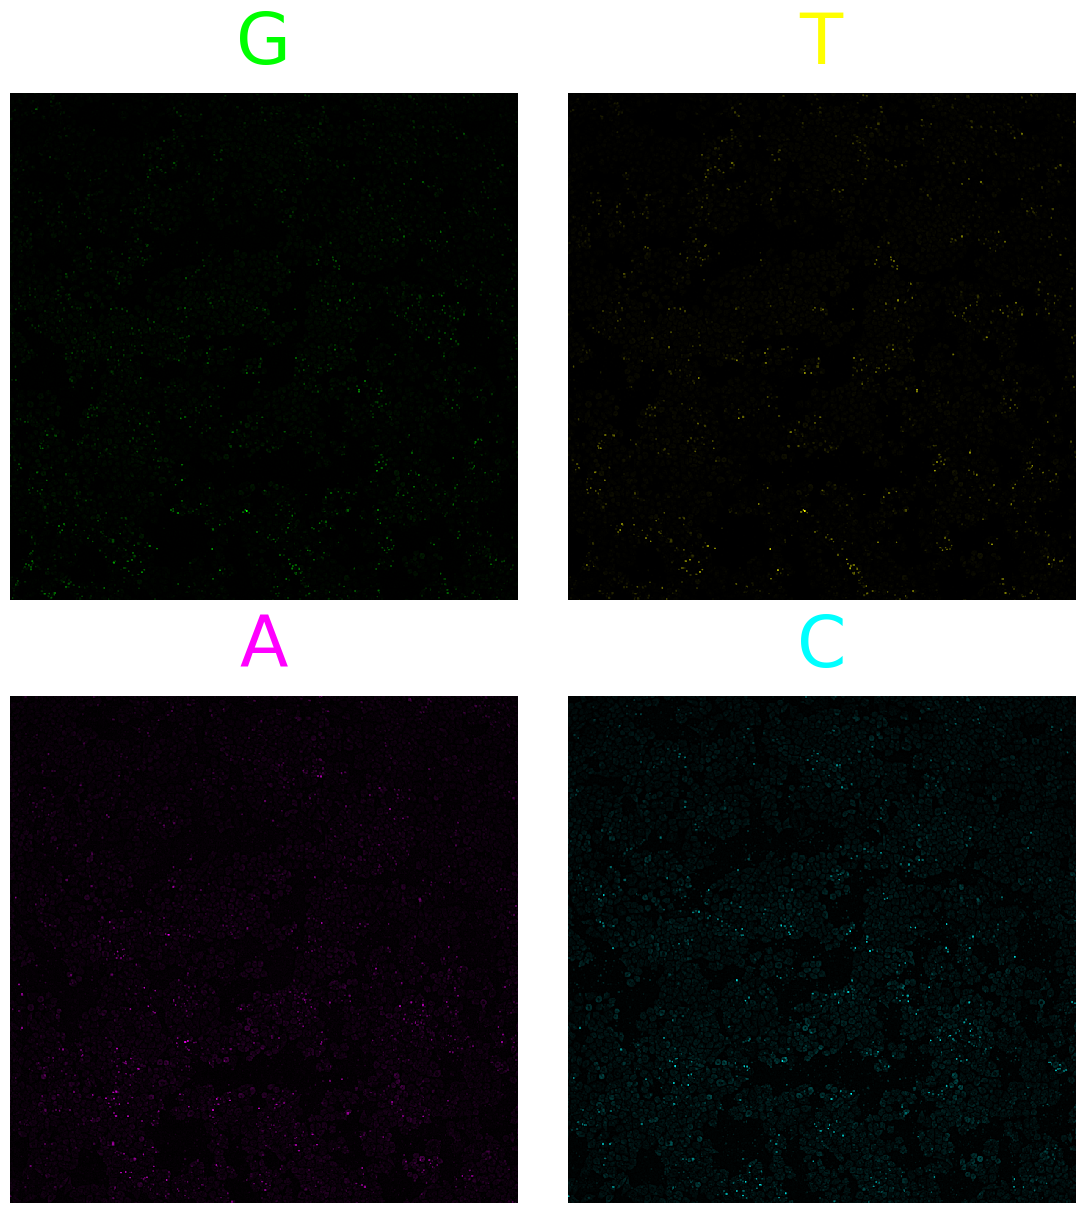

In [5]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = Snake_sbs._transform_log(aligned, skip_index=0)
save(name(description, tag='log', subdir=OUTPUT_FILES_DIR),
     loged, display_ranges=DISPLAY_RANGES, luts=LUTS)

print("Computing standard deviation over cycles...")
std = Snake_sbs._compute_std(loged, remove_index=0)
save(name(description, tag='std', subdir=OUTPUT_FILES_DIR), std)

print("Applying max filter...")
# This corresponds to the 'max_filter' rule in Snakemake
maxed = Snake_sbs._max_filter(loged, width=3, remove_index=0)
save(name(description, tag='maxed', subdir=OUTPUT_FILES_DIR),
     maxed, display_ranges=DISPLAY_RANGES[1:], luts=LUTS[1:])

print("Finding peaks...")
peaks = Snake_sbs._find_peaks(std)
save(name(description, tag='peaks', subdir=OUTPUT_FILES_DIR), peaks)

print("Example max filtered image for first cycle:")
# show max filtered data for one round
g_maxed_microshow = microplot.Microimage(maxed[0, 0, :, :],
                                         cmaps='pure_green',
                                         channel_names='G')
t_maxed_microshow = microplot.Microimage(maxed[0, 1, :, :],
                                         cmaps='pure_yellow',
                                         channel_names='T')
a_maxed_microshow = microplot.Microimage(maxed[0, 2, :, :],
                                         cmaps='pure_magenta',
                                         channel_names='A')
c_maxed_microshow = microplot.Microimage(maxed[0, 3, :, :],
                                         cmaps='pure_cyan',
                                         channel_names='C')
panel = Micropanel(rows=2, cols=2, figscaling=6)
panel.add_element([0, 0], g_maxed_microshow)
panel.add_element([0, 1], t_maxed_microshow)
panel.add_element([1, 0], a_maxed_microshow)
panel.add_element([1, 1], c_maxed_microshow)
panel.add_channel_label()

## SET PARAMETERS

### Illumination correction and segmentation

- `SEGMENTATION_CYCLE`: Determines which cycle is used for segmentation and illumination correction. Typically, this is set to the cycle with the brightest or clearest signal for cell boundaries, but in the case that we have just taken one multichannel image, it is set to that.
- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.

In [6]:
# Define cycle to use for segmentation, -1 for last cycle
SEGMENTATION_CYCLE = -1

# Define Cellpose segmentation parameters
DAPI_INDEX = 0
CYTO_CHANNEL = 4

In [7]:
print("Applying illumination correction to segmentation cycle image...")
# Read the illumination correction file
icf_file_path = f"{INPUT_FILES_DIR}/sbs_ic_tifs/10X_c{SBS_CYCLES[SEGMENTATION_CYCLE]}-SBS-{SBS_CYCLES[SEGMENTATION_CYCLE]}_{WELLS}.sbs.illumination_correction.tif"
correction_image = read(icf_file_path)
ic_segmentation_image = Snake_sbs._apply_illumination_correction(
    aligned[SEGMENTATION_CYCLE], correction=correction_image)
save(name(description, tag='illumination_correction', subdir=OUTPUT_FILES_DIR),
     ic_segmentation_image, display_ranges=DISPLAY_RANGES, luts=LUTS)

print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = Snake_sbs._prepare_cellpose(
    ic_segmentation_image, DAPI_INDEX, CYTO_CHANNEL)
save(name(description, tag='prepared_cellpose',
     subdir=OUTPUT_FILES_DIR), cellpose_rgb)
# note, this process is done during the _segment_cellpose method below as well
# use the prepared_cellpose image to test CellPose (see below)

Applying illumination correction to segmentation cycle image...
Preparing IC segmentation image for CellPose...


/opt/homebrew/anaconda3/envs/ops_dev/lib/python3.11/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


## SET PARAMETERS

### Illumination correction and segmentation

- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

For Cellpose segmentation, we strongly suggest calibrating via the Cellpose GUI. Follow these steps:

1. Open a terminal window
2. SSH onto fry: `ssh -Y username@fry.wi.mit.edu`
3. Activate a conda environment with cellpose[gui]: `conda activate ops_viewing`
4. Launch Cellpose: `python -m cellpose`
5. Open the prepared Cellpose image: `output/test/10X_well_Tile-nn.prepared_cellpose.tif`
6. Calibrate cyto3 model:
   - For cell diameter: use chan to segment = 2, chan2 = 3
   - For nuclei diameter: use chan to segment = 3, chan2 = 0

Note: You may want to adjust the diameter parameters and segment to test if you feel like you are capturing too little or too much area for either of the two masks.

In [8]:
# Parameters for cellpose method
NUCLEI_DIAMETER = 13.2  # Calibrate with CellPose
CELL_DIAMETER = 19.5  # Calibrate with CellPose
CYTO_MODEL = "cyto3"

Segmenting IC segmentation image with CellPose...


/opt/homebrew/anaconda3/envs/ops_dev/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filenam

removing edges
reconciling masks with method how=consensus


found 3119 nuclei/cells after reconciling


Number of nuclei segmented: 3119
Number of cells segmented: 3119
Example microplots for DAPI channel and nuclei segmentation:


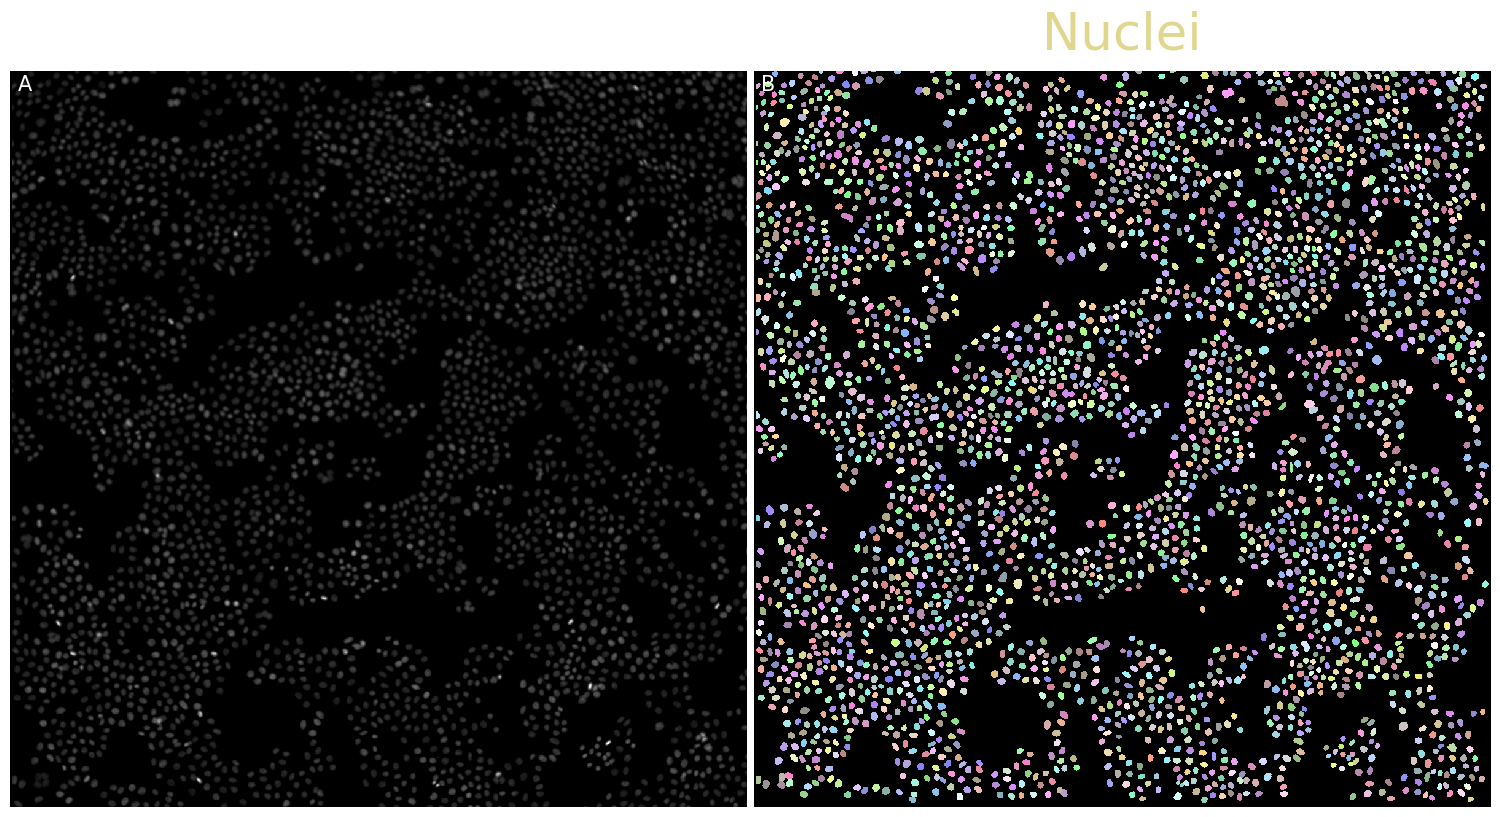

Example microplots for merged channels and cells segmentation:


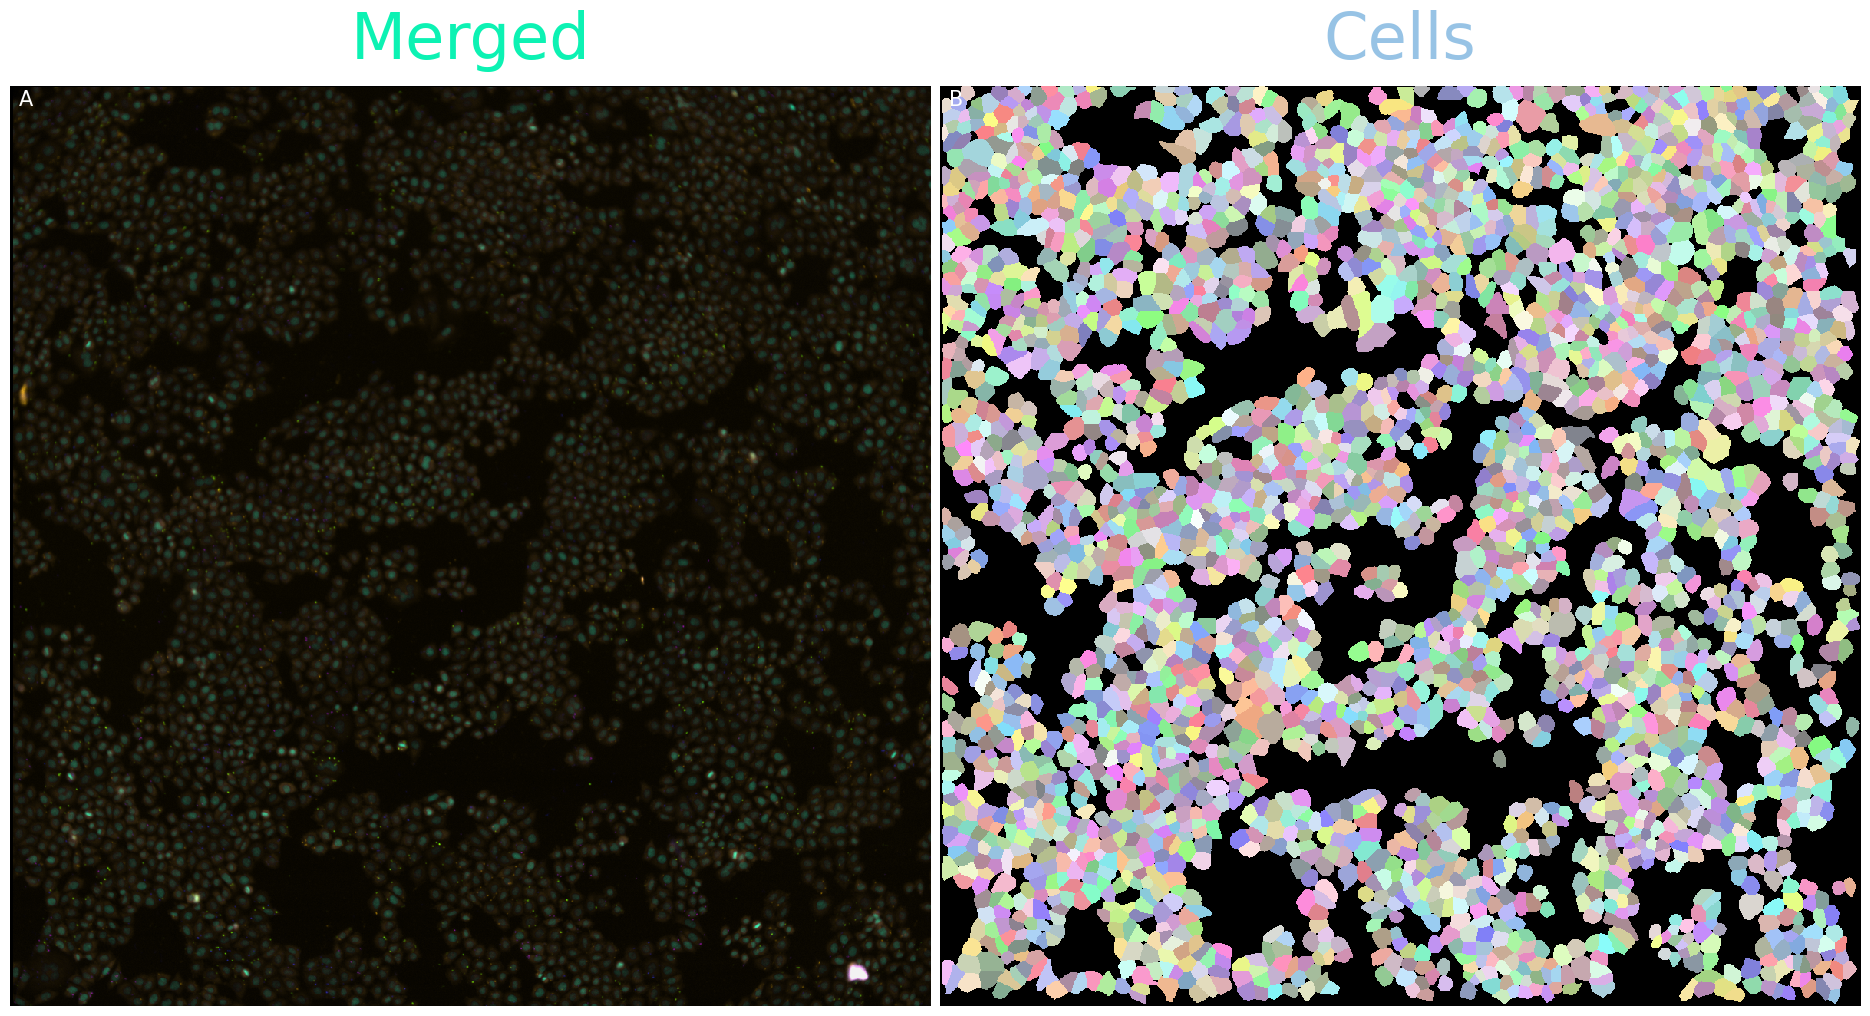

Annotating segmentation on sequencing data...
Example microplot for annotated segementation data:


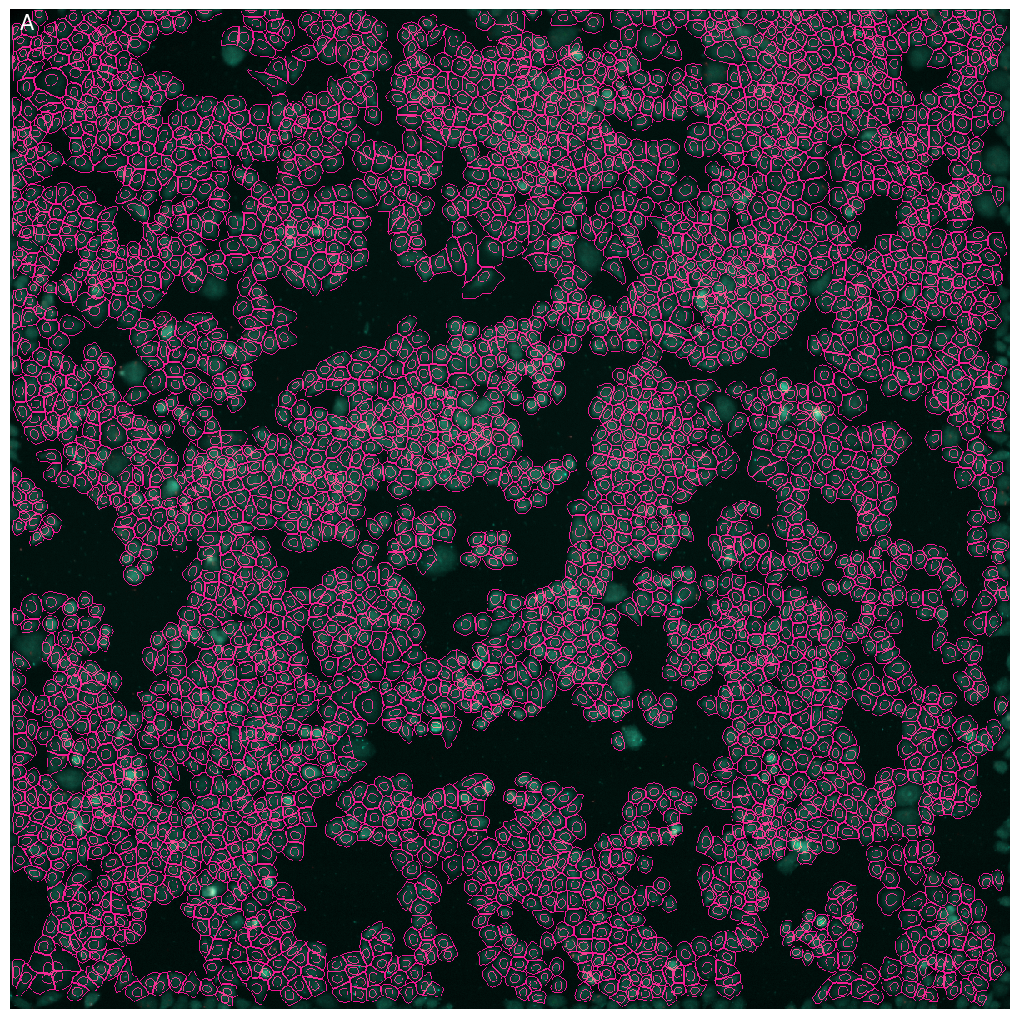

In [9]:
print("Segmenting IC segmentation image with CellPose...")
nuclei, cells = Snake_sbs._segment_cellpose(
    ic_segmentation_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_CHANNEL,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL
)
save(name(description, tag='nuclei', subdir=OUTPUT_FILES_DIR), nuclei, compress=1)
save(name(description, tag='cells', subdir=OUTPUT_FILES_DIR), cells, compress=1)

print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(ic_segmentation_image[0, :, :],
                                      rescale_type='limits',
                                      limits=DISPLAY_RANGES[0],
                                      label_text='A',
                                      channel_names='Dapi')

nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(nuclei,
                                        label_text='B',
                                        cmaps=nuclei_cmap,
                                        channel_names='Nuclei')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(ic_segmentation_image,
                                     label_text='A',
                                     rescale_type='limits',
                                     limits=DISPLAY_RANGES,
                                     channel_names='Merged')

cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells,
                                       label_text='B',
                                       cmaps=cells_cmap,
                                       channel_names='Cells')

panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Annotating segmentation on sequencing data...")
annotated_data = Snake_sbs._annotate_segment_on_sequencing_data(
    aligned, nuclei, cells)
save(name(description, tag='segmentation', subdir=OUTPUT_FILES_DIR), annotated_data)

print("Example microplot for annotated segementation data:")
annotated_microshow = microplot.Microimage(
    annotated_data[0, :, :, :], label_text='A', channel_names='Merged')
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

## SET PARAMETERS

### Extract base intensity, call reads, assign to cells

- `DF_DESIGN_PATH`: The path to your guide RNA design file
- `THRESHOLD_READS`: The intensity threshold for detecting sequencing reads. Adjust this value based on the signal-to-noise ratio in your data.
- `BASES`: The order of bases used in your sequencing. This should match the order of channels in your sequencing data.
The following cell contains an important parameter for filtering sequencing reads based on their quality. Please review and adjust this variable based on your specific experimental needs before proceeding with the analysis.

In [10]:
# Define parameters for extracting bases
DF_DESIGN_PATH = "input/pool10_design.csv"
THRESHOLD_READS = 315
BASES = "GTAC"

Extracting bases...


/Users/roshankern/Desktop/Github/OpticalPooledScreens/ops/in_situ.py:72: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = (df.stack([CYCLE, CHANNEL])


read  cycle channel  intensity  cell     i    j  tile well
176        4      1       G         44     0     7   62     1   A1
177        4      1       T         15     0     7   62     1   A1
178        4      1       A        225     0     7   62     1   A1
179        4      1       C        208     0     7   62     1   A1
180        4      2       G        505     0     7   62     1   A1
...      ...    ...     ...        ...   ...   ...  ...   ...  ...
147395  3349     10       C        789  3117  1184  247     1   A1
147396  3349     11       G          8  3117  1184  247     1   A1
147397  3349     11       T          2  3117  1184  247     1   A1
147398  3349     11       A       2095  3117  1184  247     1   A1
147399  3349     11       C        828  3117  1184  247     1   A1

[148676 rows x 9 columns]

Base intensity across cycles:


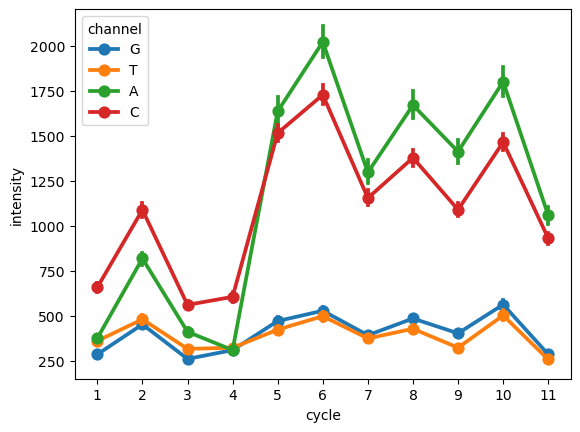

Intensity for each base:


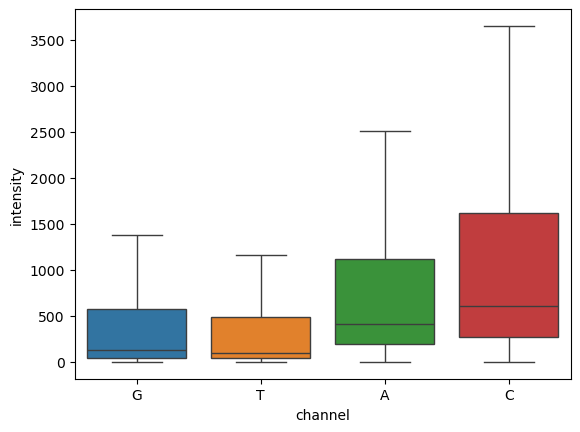

Calling reads...


read  cell     i     j  tile well      barcode       Q_0  Q_1  \
178        4     0     7    62     1   A1  ATAATAAGCCC  0.000000  1.0   
266        6     0     7   585     1   A1  TTGAAAGCCTT  1.000000  1.0   
1542      35     0    17  1116     1   A1  TGTGTGGTCAC  0.738140  1.0   
1762      40     0    21   662     1   A1  ATCATCTCCAG  0.000000  1.0   
2246      51     0    25   679     1   A1  ATCATCTCCAG  0.738140  1.0   
...      ...   ...   ...   ...   ...  ...          ...       ...  ...   
147446  3351  3115  1184   634     1   A1  GGAGAGACAGC  0.943358  1.0   
148062  3365  3115  1190   632     1   A1  GGAAAGACAGC  1.000000  1.0   
147226  3346  3116  1183  1033     1   A1  TCTGGCGGGCG  1.000000  1.0   
147622  3355  3116  1185  1043     1   A1  TCCTGACCCTA  1.000000  1.0   
147358  3349  3117  1184   247     1   A1  TGTACATATAA  1.000000  1.0   

             Q_2       Q_3  Q_4  Q_5       Q_6  Q_7      Q_8  Q_9     Q_10  \
178     1.000000  1.000000  1.0  1.0  1.000000  1.0  0.73814  1.0  0.73814   
266     1.000000  0.415037  1.0  1.0  1.000000  1.0  1.00000  1.0  1.00000   
1542    1.000000  1.000000  1.0  1.0  0.415037  1.0  1.00000  1.0  0.73814   
1762    0.738140  0.738140  1.0  1.0  1.000000  1.0  0.73814  1.0  0.73814   
2246    1.000000  1.000000  1.0  1.0  1.000000  1.0  1.00000  1.0  1.00000   
...          ...       ...  ...  ...       ...  ...      ...  ...      ...   
147446  0.415037  1.000000  1.0  1.0  1.000000  1.0  1.00000  1.0  1.00000   
148062  0.000000  0.000000  1.0  1.0  1.000000  1.0  1.00000  1.0  1.00000   
147226  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.00000  1.0  1.00000   
147622  0.738140  1.000000  1.0  1.0  0.773706  1.0  1.00000  1.0  1.00000   
147358  0.738140  0.000000  1.0  1.0  1.000000  1.0  1.00000  1.0  1.00000   

           Q_min        peak  
178     0.000000  380.579449  
266     0.415037  521.307155  
1542    0.415037  441.689510  
1762    0.000000  330.331696  
2246    0.738140  647.080587  
...          ...         ...  
147446  0.415037  739.324910  
148062  0.000000  354.451385  
147226  1.000000  672.680700  
147622  0.738140  395.615308  
147358  0.000000  434.624404  

[3379 rows x 20 columns]

Mapping rate vs. peak threshold for determining optimal peak cutoff:


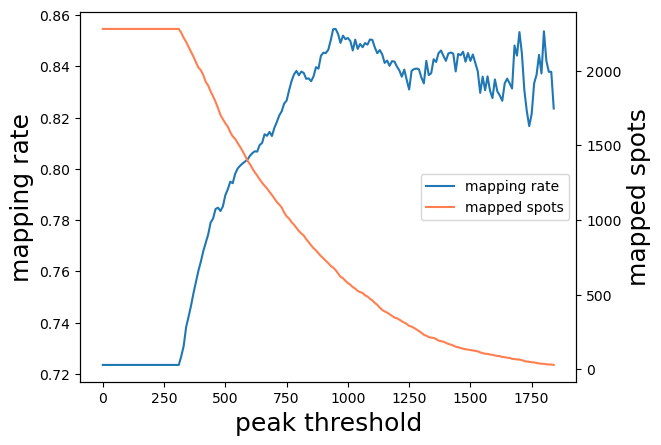

Mapping rate vs. Q_min for determining optimal sequence quality cutoff:


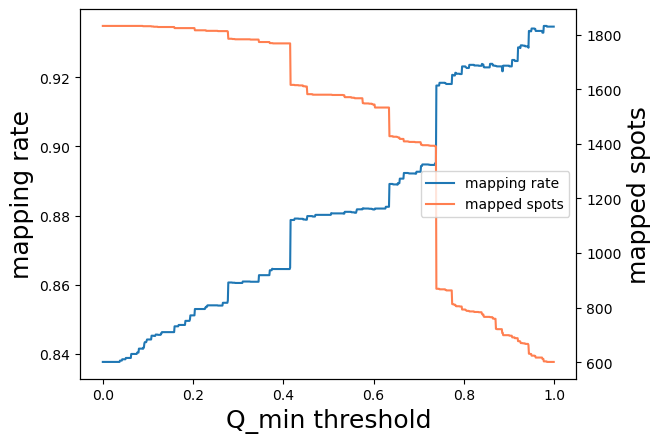

Annotating bases on SBS LoG...


/Users/roshankern/Desktop/Github/OpticalPooledScreens/ops/annotate.py:169: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(bases.index)


Annotating bases on SBS read peaks (return reads)...


/Users/roshankern/Desktop/Github/OpticalPooledScreens/ops/annotate.py:169: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(bases.index)
/Users/roshankern/Desktop/Github/OpticalPooledScreens/ops/annotate.py:169: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(bases.index)
/Users/roshankern/Desktop/Github/OpticalPooledScreens/ops/sbs_smk.py:912: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  peaks_donut = skimage.morphology.dilation(peaks, selem=donut)


Annotating bases on SBS read peaks (return peaks)...


/Users/roshankern/Desktop/Github/OpticalPooledScreens/ops/annotate.py:169: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(bases.index)
/Users/roshankern/Desktop/Github/OpticalPooledScreens/ops/annotate.py:169: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(bases.index)
/Users/roshankern/Desktop/Github/OpticalPooledScreens/ops/sbs_smk.py:912: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  peaks_donut = skimage.morphology.dilation(peaks, selem=donut)


In [11]:
# Read and format guide data
df_design = pd.read_csv(DF_DESIGN_PATH)
df_pool = df_design.query("dialout==[0,1]").drop_duplicates("sgRNA")
df_pool["prefix"] = df_pool.apply(
    lambda x: x.sgRNA[: x.prefix_length], axis=1)  # 13
barcodes = df_pool["prefix"]

print("Extracting bases...")
df_bases = Snake_sbs._extract_bases(maxed, peaks, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES)
df_bases.to_csv(name(description, tag='bases', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
display(df_bases)

print("Base intensity across cycles:")
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

print("Intensity for each base:")
ax = sns.boxplot(x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False)
plt.show()

print("Calling reads...")
df_reads = Snake_sbs._call_reads(df_bases, peaks=peaks)
df_reads.to_csv(name(description, tag='reads', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
display(df_reads)

print("Mapping rate vs. peak threshold for determining optimal peak cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "peak")
plt.show()

print("Mapping rate vs. Q_min for determining optimal sequence quality cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "Q_min")
plt.show()

# Make alternate annotation tif images
print("Annotating bases on SBS LoG...")
annotated_bases=Snake_sbs._annotate_bases_on_SBS_log(loged, df_reads)
save(name(description, tag='annotated_bases', subdir=OUTPUT_FILES_DIR), annotated_bases)
print("Annotating bases on SBS read peaks (return reads)...")
annotated_reads=Snake_sbs._annotate_bases_on_SBS_reads_peaks(loged, peaks, df_reads, df_pool, SBS_CYCLES, shape=(1200, 1200), return_channels="reads")
save(name(description, tag='annotated_reads', subdir=OUTPUT_FILES_DIR), annotated_reads)
print("Annotating bases on SBS read peaks (return peaks)...")
annotated_peaks=Snake_sbs._annotate_bases_on_SBS_reads_peaks(loged, peaks, df_reads, df_pool, SBS_CYCLES, shape=(1200, 1200), return_channels="peaks")
save(name(description, tag='annotated_peaks', subdir=OUTPUT_FILES_DIR), annotated_peaks)

## SET PARAMETERS

### Read mapping

- `Q_MIN`: The minimum Levenshtein distance allowed between a read and its closest barcode match. A value of 0 means only perfect matches are accepted, while higher values allow for more mismatches.

In [12]:
# Define parameters for read mapping
Q_MIN = 0

Corrected cells:


cell  tile well      Q_0       Q_1       Q_2       Q_3  Q_4  Q_5  \
0        6     1   A1  0.73814  0.745053  0.704629  1.000000  1.0  1.0   
1       11     1   A1  0.00000  1.000000  1.000000  1.000000  1.0  1.0   
2       12     1   A1  0.73814  0.863878  1.000000  1.000000  1.0  1.0   
3       19     1   A1  1.00000  1.000000  1.000000  1.000000  1.0  1.0   
4       20     1   A1  0.00000  0.482691  1.000000  0.884228  1.0  1.0   
...    ...   ...  ...      ...       ...       ...       ...  ...  ...   
1916  3113     1   A1  1.00000  1.000000  1.000000  0.000000  1.0  1.0   
1917  3114     1   A1  1.00000  1.000000  1.000000  1.000000  1.0  1.0   
1918  3115     1   A1  1.00000  1.000000  0.738140  0.738140  1.0  1.0   
1919  3116     1   A1  1.00000  1.000000  1.000000  1.000000  1.0  1.0   
1920  3117     1   A1  1.00000  1.000000  0.738140  0.000000  1.0  1.0   

           Q_6  ...  cell_barcode_count_0  cell_barcode_1  \
0     1.000000  ...                     1             NaN   
1     1.000000  ...                     1             NaN   
2     1.000000  ...                     1             NaN   
3     1.000000  ...                     1             NaN   
4     0.203511  ...                     1             NaN   
...        ...  ...                   ...             ...   
1916  1.000000  ...                     1             NaN   
1917  1.000000  ...                     1             NaN   
1918  1.000000  ...                     2     GGAAAGACAGC   
1919  1.000000  ...                     1     TCTGGCGGGCG   
1920  1.000000  ...                     1             NaN   

      cell_barcode_count_1  barcode_count               sgRNA_0  \
0                      0.0              1  AGGATACTGCTGGTCAAGAG   
1                      0.0              1                   NaN   
2                      0.0              1  AGCTCGTAAATTAAATCACC   
3                      0.0              1  TCTGCTCGTAGGTGTACAGG   
4                      0.0              1                   NaN   
...                    ...            ...                   ...   
1916                   0.0              1                   NaN   
1917                   0.0              1  TCTGAGCATGACCCGGGACG   
1918                   1.0              3  GGAGAGACAGCTAATGAGTG   
1919                   1.0              2  TCCTGACCCTAGCACCACGG   
1920                   0.0              1                   NaN   

      gene_symbol_0  gene_id_0               sgRNA_1  gene_symbol_1 gene_id_1  
0             RAB18      22931                   NaN            NaN       NaN  
1               NaN        NaN                   NaN            NaN       NaN  
2              SYF2      25949                   NaN            NaN       NaN  
3             PAQR3     152559                   NaN            NaN       NaN  
4               NaN        NaN                   NaN            NaN       NaN  
...             ...        ...                   ...            ...       ...  
1916            NaN        NaN                   NaN            NaN       NaN  
1917          PHKG1       5260                   NaN            NaN       NaN  
1918           NASP       4678                   NaN            NaN       NaN  
1919          GATA2       2624  TCTGGCGGGCGAGCTCACGC          SERF2     10169  
1920            NaN        NaN                   NaN            NaN       NaN  

[1921 rows x 28 columns]

Minimal phenotype features:


area            i            j  cell                    bounds  tile  \
0       67     5.835821    33.970149     1           (2, 30, 11, 39)     1   
1       23     3.217391   108.869565     2          (2, 106, 6, 113)     1   
2       49     3.653061   139.346939     3          (2, 134, 7, 146)     1   
3       66     4.712121   164.333333     4          (2, 159, 9, 170)     1   
4       48     3.625000   178.562500     5          (2, 173, 7, 185)     1   
...    ...          ...          ...   ...                       ...   ...   
3114    75  1185.693333   632.493333  3115    (1182, 627, 1190, 639)     1   
3115    89  1185.842697  1036.539326  3116  (1182, 1031, 1191, 1043)     1   
3116    87  1187.459770   257.540230  3117    (1183, 253, 1193, 263)     1   
3117    88  1187.556818   732.943182  3118    (1183, 728, 1194, 739)     1   
3118    73  1187.136986  1166.191781  3119  (1183, 1162, 1193, 1172)     1   

     well  
0      A1  
1      A1  
2      A1  
3      A1  
4      A1  
...   ...  
3114   A1  
3115   A1  
3116   A1  
3117   A1  
3118   A1  

[3119 rows x 7 columns]

Summary of the fraction of cells mapping to one barcode:


well  tile  fraction of cells mapping to 1 barcode
1   A1     1                                0.433472

Summary of the fraction of cells mapping to any barcode:


well  tile  fraction of cells mapping to >=1 barcode
1   A1     1                                  0.498237

Histogram of the number of reads per cell:


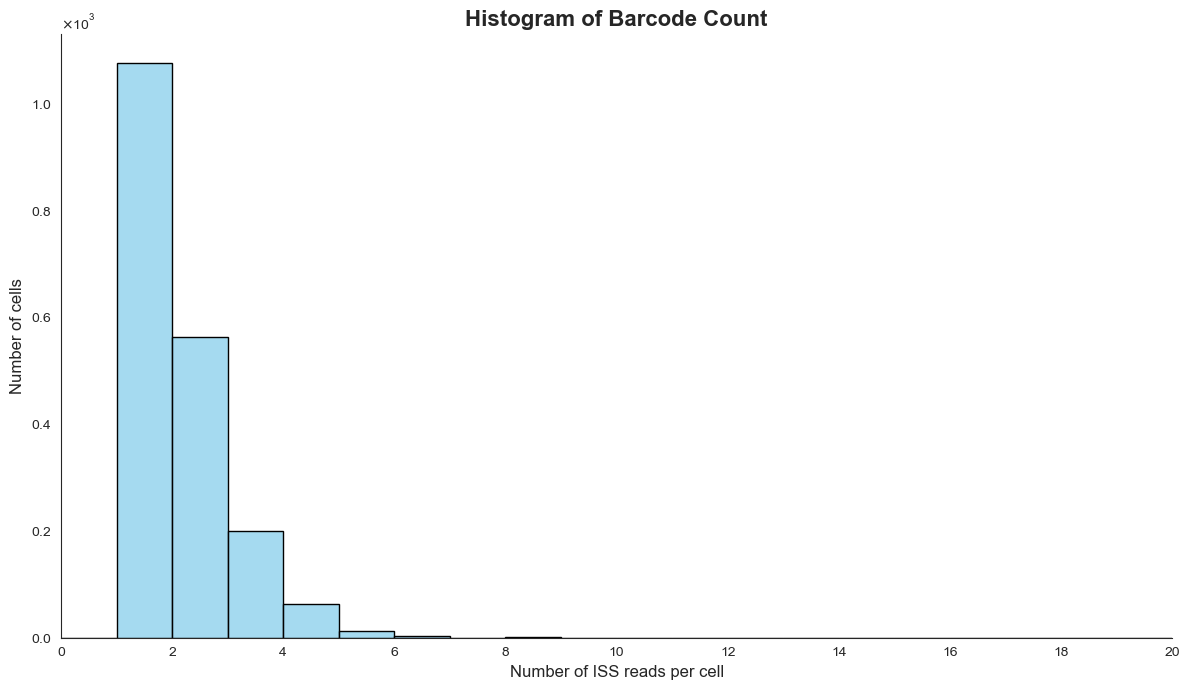

Histogram of the number of counts of each unique gene symbols:


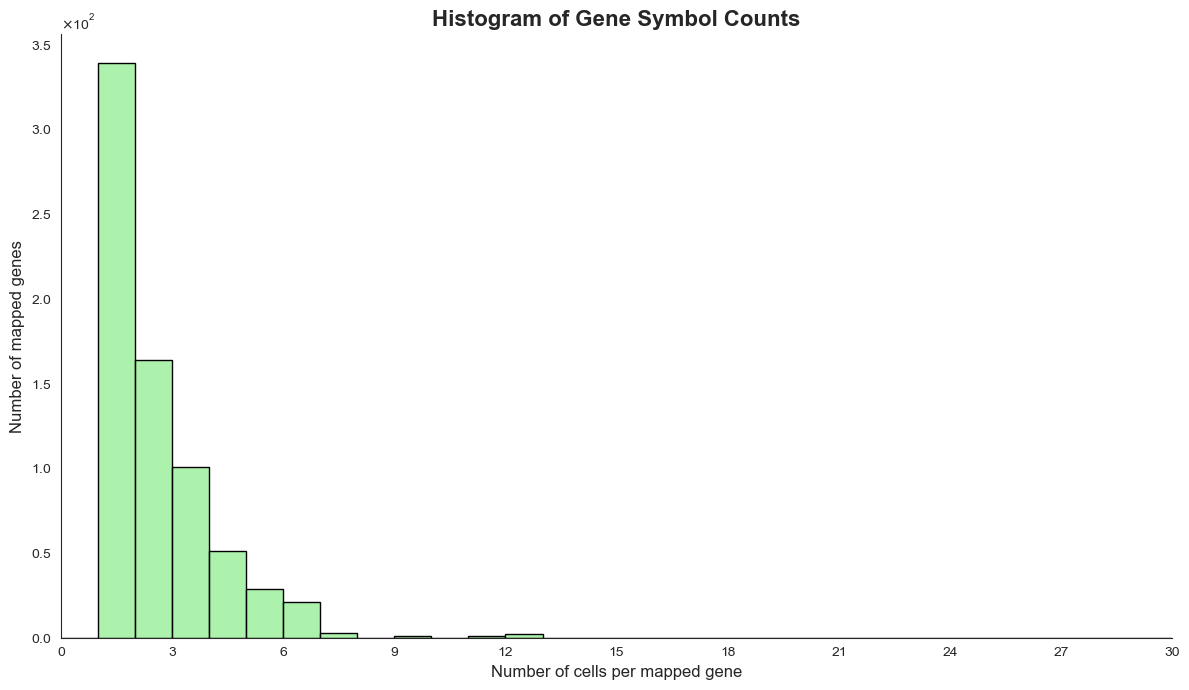

In [13]:
print("Corrected cells:")
df_cells = Snake_sbs._call_cells(df_reads, df_pool=df_pool, q_min=Q_MIN)
df_cells.to_csv(name(description, tag='cells', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
display(df_cells)

print("Minimal phenotype features:")
df_sbs_info = Snake_sbs._extract_phenotype_minimal(data_phenotype=nuclei, nuclei = nuclei, wildcards=WILDCARDS)
df_sbs_info.to_csv(name(description, tag='sbs_info', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
display(df_sbs_info)

print("Summary of the fraction of cells mapping to one barcode:")
one_barcode_mapping = plot_cell_mapping_heatmap(df_cells, df_sbs_info, barcodes, mapping_to='one', mapping_strategy='gene_symbols', shape='6W_sbs', return_plot=False, return_summary=True)
display(one_barcode_mapping)

print("Summary of the fraction of cells mapping to any barcode:")
any_barcode_mapping = plot_cell_mapping_heatmap(df_cells, df_sbs_info, barcodes, mapping_to='any', mapping_strategy='gene_symbols', shape='6W_sbs', return_plot=False, return_summary=True)
display(any_barcode_mapping)

print("Histogram of the number of reads per cell:")
outliers = plot_reads_per_cell_histogram(df_cells, x_cutoff = 20)
plt.show()

print("Histogram of the number of counts of each unique gene symbols:")
outliers = plot_gene_symbol_histogram(df_cells, x_cutoff = 30)
plt.show()